# Measurement of the signal strength

$$\mathcal{L} (\mu | x) = \prod_{i}^{n} p (x_i | \mu) $$

In [53]:
import json

import pandas as pd
import numpy as np

import torch
from torch.utils.data import TensorDataset, DataLoader
torch.set_default_dtype(torch.float32)
torch.set_float32_matmul_precision('medium')
import lightning as L

from physics.simulation import mcfm
from physics.analysis import zz4l, zz2l2v
from physics.hstar import sigstr
from nsbi import carl

import matplotlib, matplotlib.pyplot as plt

# 0. Define the parameter space

The first thing to do is to define the parameter space that will define the set of hypotheses we wish to test.
For us, this is the signal strength parameter, which we will test between 0 and 4:

$$ 0 \leq \mu \leq 4 $$

In [54]:
mu_space = torch.linspace(0.0, 4.0, 401)

# 1. Open the "mystery" dataset

A dataset has been generated according to an unknown (to you) value of $\mu$ at the LHC luminosity of $300\,\mathrm{fb}^{-1}$. Let's open this dataset and read out for each event its (1) observables, and (2) number of occurrences.

In [ ]:
lumi = 300.0  # ifb
events_obs = pd.read_csv('/ptmp/mpp/taepa/2025-lbnl/sessions/day2/nsbi-tutorial/data/for_sean/observed_30.csv')

features = ['l1_pt', 'l1_eta', 'l1_phi', 'l1_energy', 'l2_pt', 'l2_eta', 'l2_phi', 'l2_energy', 'l3_pt', 'l3_eta', 'l3_phi', 'l3_energy', 'l4_pt', 'l4_eta', 'l4_phi', 'l4_energy']
events_obs_features = events_obs[features]

events_obs_n        = events_obs['n']  # Why is this not always 1 for each entry? See note!

Note: this is a _simulated_ dataset, meaning that the number of occurrences of an event is not always an integer. Of course keep in mind that in a real LHC dataset, each entry represents exactly one entry. Alwyas keep this in mind when counting/summing over the events below!

## 2. Evaluating the likelihood: rate term

As already introduced, our likelihood function is composed of two terms, the first of which can be readily evaluated as

$$\mathcal{L}_{\mathrm{rate}}(\mu | \mathcal{D}) = \mathcal{P}(n ; \nu(\mu)) = \frac{\nu^{n}(\mu) e^{-\nu(\mu)}}{n!},$$

where $n$ is the total number of events in the observed dataset, and $\nu(\mu)$ is the expected number of events, which (of course) depends on the $\mu$-hypothesis.

### 2.(b) Compute the total expected number of events, $\nu(\mu = 1)$

The expected number of events is given by the cross section times luminosity:

$$\nu(\mu) = \sigma(\mu) \times L$$

where the cross section, of course, depends on the POI. These correspond to "visual" cross sections, i.e. after detector acceptance/efficiency effects, of the total $gg\to(h^{\ast}\to)ZZ\to 4\ell$ process. The independent signal/background/interference contributions to the signal+background+interference hypothesis is available.

In [56]:
with open('data/sm_gg4l_xs.json', 'r') as f:
    xs = json.load(f)  # fb
    xs_sig_sm = np.prod(xs['sig'])
    xs_bkg_sm = np.prod(xs['bkg'])
    xs_int_sm = np.prod(xs['int'])
    xs_sbi_sm = np.prod(xs['sbi'])

nu_sig_sm = xs_sig_sm * lumi
nu_bkg_sm = xs_bkg_sm * lumi
nu_int_sm = xs_int_sm * lumi
nu_sbi_sm = xs_sbi_sm * lumi

### 2.(c) Compute the total expected number of events as a function of $\mu$

The SM-expected cross section and event yields correspond to the $\mu = 1$ hypothesis. Now we must compute how this changes as a function of our parameter of interest according to the following:

$$\nu_{\mathrm{SBI}}(\mu) = \mu \nu_{\mathrm{S}}(1) + \sqrt{\mu} \nu_{\mathrm{I}}(1) + \nu_{\mathrm{B}}(1)$$

In [57]:
nu_sig_mu = nu_sig_sm * mu_space
nu_int_mu = nu_int_sm * torch.sqrt(mu_space)
nu_bkg_sm = nu_bkg_sm  # I don't change!
nu_sbi_mu = nu_sig_mu + nu_int_mu + nu_bkg_sm

### 2.(d) Define & compute the Poisson likelihood

Using the quantities computed above, we can now compute the negative log likelihood (NLL) of the rate term as a function of $\mu$:

$$- \log \mathcal{L}_{\mathrm{rate}}(\mu | \mathcal{D})  = \nu(\mu) - n \log\nu(\mu) + \cancel{\log(n!)}$$

Reminder the "disappearance" of $\log (1/n!)$ term does not affect the minimization of NLL as a function of $\mu$. 

In [58]:
def neg_log_pois(n_obs, nu_exp):
    """
    Evaluates the negative log-likelihood for a Poisson process.
    """
    return nu_exp - n_obs * torch.log(nu_exp)

# IMPLEMENT ME
t_rate = neg_log_pois(events_obs_n.sum(), nu_sbi_mu)

Now let's plot our rate-only analysis result. As mentioned previous about the arbitrary minimum value of the NLL, we set it to be the zero-point of the test statistic:

$$ t \equiv - 2 \log \lambda = -2 \log (\frac{\mathcal{L}(\mu | \mathcal{D})}{\min \mathcal{L}(\mu | \mathcal{D})})$$

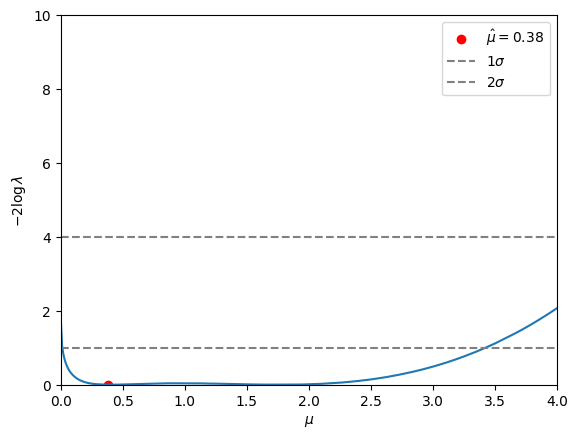

In [59]:
def plot_nll(mu_space, t):
    
    t_min = torch.min(t)
    t -= t_min

    mu_fit = mu_space[torch.argmin(t)]

    plt.plot(mu_space.cpu(), t.cpu())
    plt.xlim(0, 4)
    plt.ylim(0, 10)
    plt.scatter(mu_fit.cpu(), 0.0, color='red', label=f'$\hat{{\mu}} = {mu_fit:.2f}$')

    plt.hlines(1.0, 0, 4,color='gray', linestyle='--', label='$1\sigma$')
    plt.hlines(4.0, 0, 4,color='gray', linestyle='--', label='$2\sigma$')

    plt.xlabel('$\mu$')
    plt.ylabel('$-2 \log \lambda$')

    plt.legend()
    
    plt.show()

plot_nll(mu_space, t_rate)

Do you notice anything strange about the NLL curve? Perhaps more than one possible minimum?

## 3. Evaluating the likelihood (ratio): shape term

Here comes NSBI, which will estimate the shape term of our likelihood, and (hopefully) improve our results!

### 3.(a) Load the NN models

Let's first load the CARL models that we've trained in the previous tutorial.

In [60]:
run_dir = 'run/h4l'
# we ignore the first two objects, which are the picked training & validation datasets
_, _, scaler_sbi_over_bkg, model_sbi_over_bkg = carl.utils.load_results(run_dir, 'sbi_over_bkg')
_, _, scaler_sig_over_bkg, model_sig_over_bkg = carl.utils.load_results(run_dir, 'sig_over_bkg')


### 3.(b) Run the models over the dataset, and perform the likelihood ratio trick

This part should also be straightforward, given the previous exercise:

1. Obtain the features of the dataset.
2. Scale the features using the scaler from training.
3. Run the model over the scaled features.
4. Perform the likelihood trick over the output.

In [61]:
torch.cuda.empty_cache()

In [62]:
X_sig_over_bkg_sm = scaler_sig_over_bkg.transform(events_obs_features.to_numpy())
X_sbi_over_bkg_sm = scaler_sbi_over_bkg.transform(events_obs_features.to_numpy())

dl_sig_over_bkg_sm = DataLoader(TensorDataset(torch.tensor(X_sig_over_bkg_sm, dtype=torch.float32)), batch_size=1024) 
dl_sbi_over_bkg_sm = DataLoader(TensorDataset(torch.tensor(X_sbi_over_bkg_sm, dtype=torch.float32)), batch_size=1024) 

trainer = L.Trainer(accelerator='gpu', devices=1)
s_sig_over_bkg_sm = torch.cat(trainer.predict(model_sig_over_bkg, dl_sig_over_bkg_sm))
s_sbi_over_bkg_sm = torch.cat(trainer.predict(model_sbi_over_bkg, dl_sbi_over_bkg_sm))

r_sig_over_bkg_sm = s_sig_over_bkg_sm / (1 - s_sig_over_bkg_sm)
r_sbi_over_bkg_sm = s_sbi_over_bkg_sm / (1 - s_sbi_over_bkg_sm)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/afs/ipp-garching.mpg.de/home/t/taepa/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: |                                                                                                 …

### 3.(c) Evaluate the probability density ratio

$$
\sigma_{\rm SBI} = \sigma_{\rm S} + \sigma_{\rm I} + \sigma_{\rm B}
$$

$$
\mu \sigma_{\rm S} + \sqrt{\mu} \sigma_{\rm I} + \sigma_{\rm B} =  (\mu - \sqrt{\mu}) \sigma_{\rm S} + \sqrt{\mu} \sigma_{\rm SBI} + (1-\sqrt{\mu}) \sigma_{\rm B} 
$$

$$
\frac{p_{\rm SBI} (x | \mu)}{p_{\rm B} (x)} = \frac{ (\mu - \sqrt{\mu}) \sigma_{\rm S} r_{\rm S} + \sqrt{\mu} \sigma_{\rm SBI} r_{\rm SBI} + (1-\sqrt{\mu}) \sigma_{\rm B} }{ \mu \sigma_{\rm S} + \sqrt{\mu} \sigma_{\rm I} + \sigma_{\rm B} }
$$

Tip: if you want to compute all elements of the $N \times M$ tensor where $N$ is the number of entries in the dataset and $M$ is the number of $\mu$ values being tested, then you can utilize tensor broadcasting, here's an example:
```py
a.shape  # (N,)
b.shape  # (M,)
c = a[:,None] * b[None,:]
c.shape  # (N, M)
```

In [63]:
multiplier_sig = mu_space - torch.sqrt(mu_space)
multiplier_sbi = torch.sqrt(mu_space)
multiplier_bkg = 1 - torch.sqrt(mu_space)

r_sbi_over_bkg_mu = ( xs_sig_sm * multiplier_sig[None,:] * r_sig_over_bkg_sm[:,None] + xs_sbi_sm * multiplier_sbi[None,:] * r_sbi_over_bkg_sm[:,None] + xs_bkg_sm * multiplier_bkg[None,:] ) / (xs_sig_sm * mu_space + xs_int_sm * torch.sqrt(mu_space) + xs_bkg_sm)

Evaluate 

$$t_{\rm shape} = - \sum_{i=1}^{n} \left( \log \frac{p_{\rm SBI} (x | \mu)}{p_{\rm B} (x)} \right)$$

Note: keep in mind that we are dealing with a simulated dataset, where each event has a non-integer number of occurences! So the sum over $i=1,\dots, n$ must be adjusted to account for this:

$$
t_{\rm shape} = - \sum_{i=1}^{m} \left( \log \frac{p_{\rm SBI} (x | \mu)}{p_{\rm B} (x)} \right)^{w_i} $$
$$

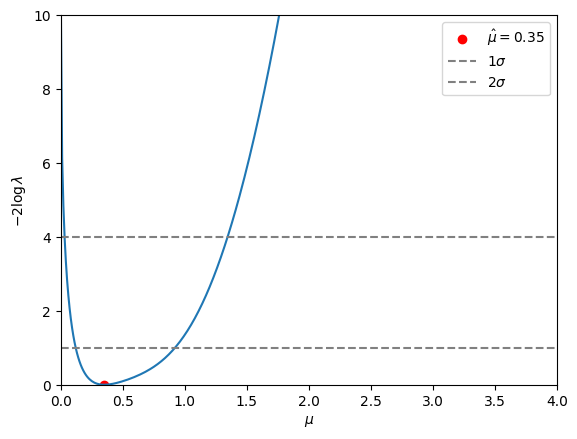

In [64]:
t_shape = -2 * torch.sum(torch.tensor(events_obs_n)[:,None] * torch.log(r_sbi_over_bkg_mu), dim=0)

plot_nll(mu_space, t_shape)

# Evaluating the likelihood (ratio): rate + shape

$$ t = t_{\rm rate} + t_{\rm shape} $$

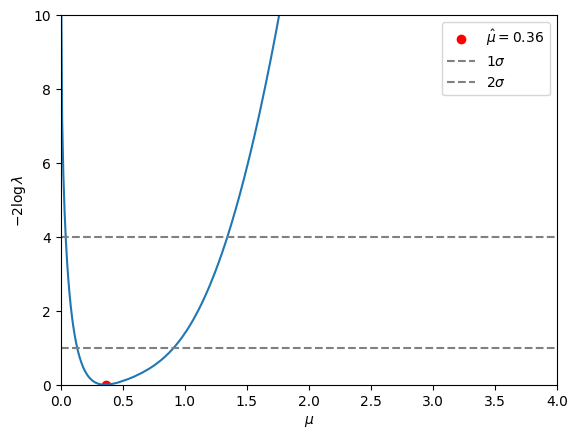

In [65]:
t = t_rate + t_shape
plot_nll(mu_space, t)